In [2]:
library(randomForest)
library(caret)
library(party)
library(rpart)
library(rpart.plot)
library(caTools)
library(dplyr)
library(ROCR)
library(e1071)

In [3]:
set.seed(2017)
N  <- 10000
x1 <- rnorm(N, sd=1.5)
x2 <- rnorm(N, sd=1.5)
y  <- apply(cbind(x1, x2), 1, function(x) xor(xor((x%*%x)<5.5, (x%*%x)>2),(x%*%x)<0.75))
# y  <- apply(cbind(x1, x2), 1, function(x) (x%*%x)<5)

In [4]:
data_junk <- matrix(rnorm(N*10, sd=1.5), ncol=10)
colnames(data_junk) <- paste(paste("x", 3:(ncol(data_junk)+2), sep=""))
data <- cbind(x1, x2, data_junk,y)
data <- data.frame(data)
data$y <- as.factor(data$y)

In [5]:
data$y[abs(data$x1-data$x2) <0.5] <- 0

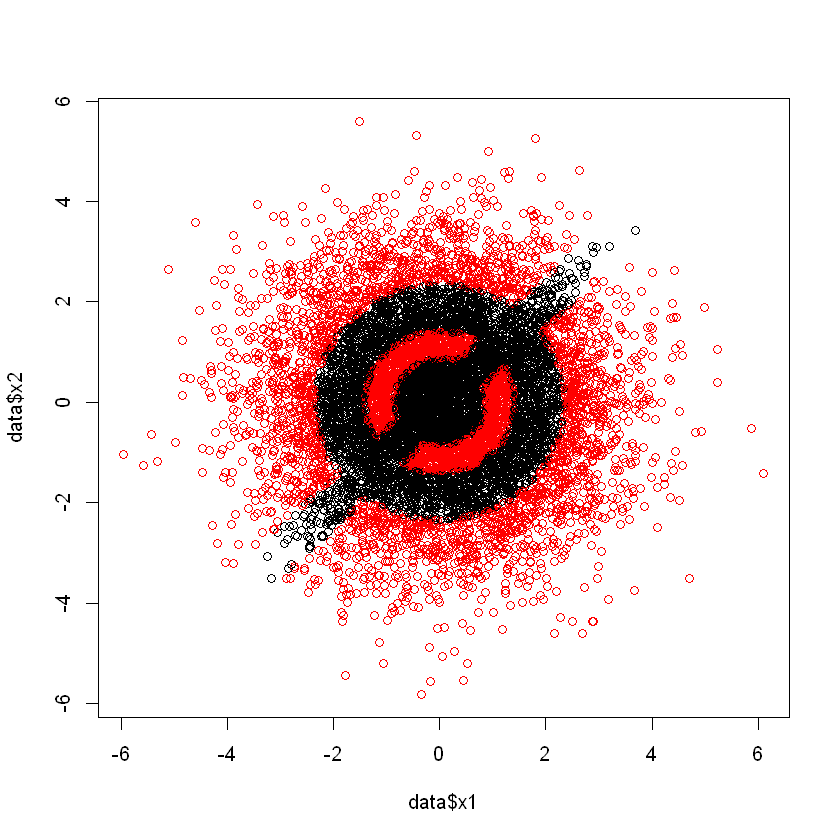

In [6]:
plot(data$x1, data$x2, col=ifelse(data$y==0, "black", "red"))

In [7]:
summary(data)

       x1                  x2                  x3           
 Min.   :-5.956246   Min.   :-5.825344   Min.   :-5.566368  
 1st Qu.:-1.050943   1st Qu.:-0.994469   1st Qu.:-0.997728  
 Median : 0.002499   Median : 0.015556   Median : 0.019896  
 Mean   :-0.006710   Mean   : 0.000589   Mean   : 0.007801  
 3rd Qu.: 1.023922   3rd Qu.: 1.010299   3rd Qu.: 1.015419  
 Max.   : 6.111088   Max.   : 5.595424   Max.   : 7.083721  
       x4                  x5                 x6                  x7           
 Min.   :-5.828862   Min.   :-5.11689   Min.   :-5.231217   Min.   :-5.813473  
 1st Qu.:-1.016531   1st Qu.:-1.03548   1st Qu.:-1.049658   1st Qu.:-1.005816  
 Median :-0.003373   Median :-0.01092   Median :-0.022800   Median : 0.013423  
 Mean   :-0.011556   Mean   :-0.00883   Mean   :-0.009661   Mean   : 0.000588  
 3rd Qu.: 0.998172   3rd Qu.: 0.99266   3rd Qu.: 1.013347   3rd Qu.: 1.025352  
 Max.   : 5.703312   Max.   : 5.25912   Max.   : 5.323360   Max.   : 6.266635  
       x8    

In [67]:
# data$x13 <- (data$x1)^2
# data$x14 <- (data$x2)^2

In [8]:
data$split1 <- sample.split(data$y, SplitRatio=0.8)
train <- subset(data, data$split==TRUE)
test <- subset(data, data$split==FALSE)
data$split1 <- NULL
train$split1 <- NULL
test$split1 <- NULL
rawtrain <- train
rawtest <- test

In [9]:
train <- rawtrain
test <- rawtest

# Random Forest

In [10]:
rf <- randomForest(as.factor(y)~x1+x2, data=train, ntree=500,importance=TRUE)

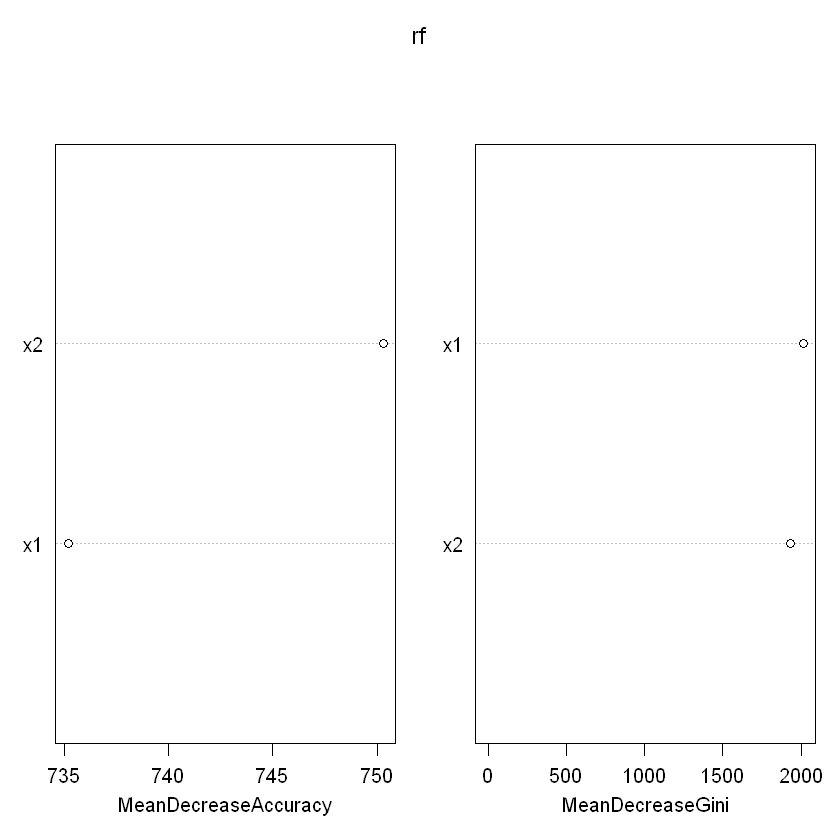

In [11]:
varImpPlot(rf)

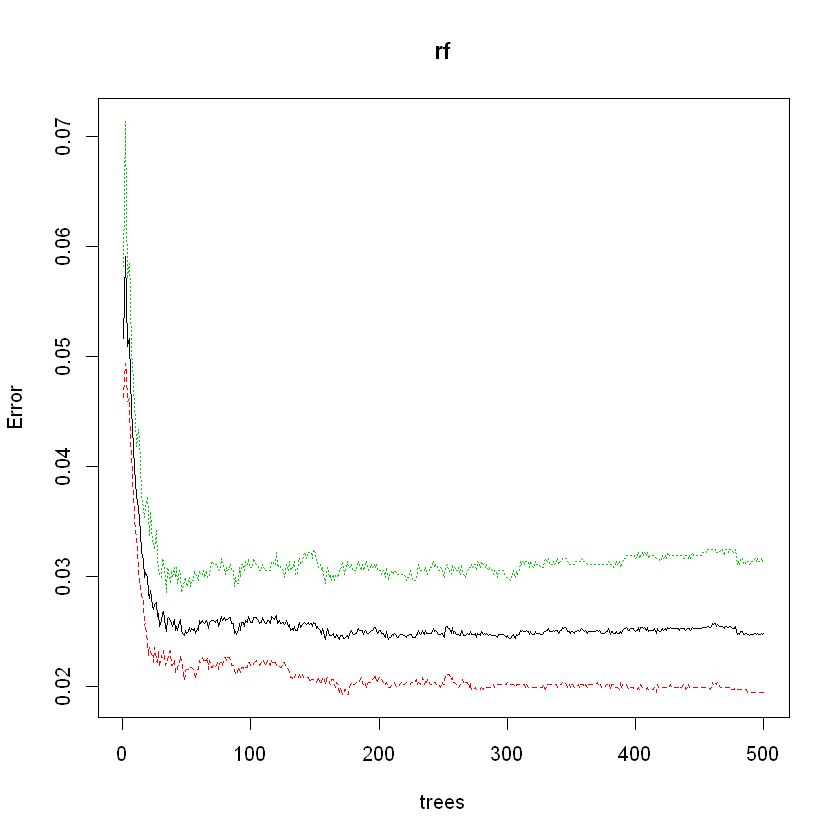

In [12]:
plot(rf)

In [13]:
test$predicted <- predict(rf,test,type="response")
test$predicted <- as.factor(test$predicted)
confusionMatrix(test$predicted, test$y)

Confusion Matrix and Statistics

          Reference
Prediction    0    1
         0 1093   31
         1   22  854
                                          
               Accuracy : 0.9735          
                 95% CI : (0.9655, 0.9801)
    No Information Rate : 0.5575          
    P-Value [Acc > NIR] : <2e-16          
                                          
                  Kappa : 0.9462          
 Mcnemar's Test P-Value : 0.2718          
                                          
            Sensitivity : 0.9803          
            Specificity : 0.9650          
         Pos Pred Value : 0.9724          
         Neg Pred Value : 0.9749          
             Prevalence : 0.5575          
         Detection Rate : 0.5465          
   Detection Prevalence : 0.5620          
      Balanced Accuracy : 0.9726          
                                          
       'Positive' Class : 0               
                                          

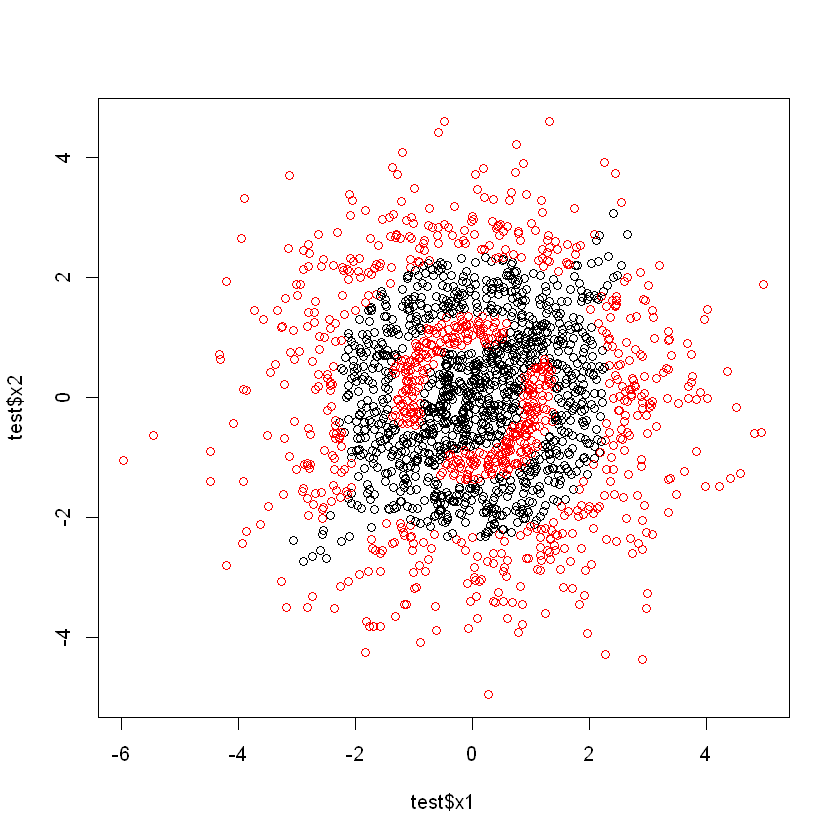

In [14]:
plot(test$x1, test$x2, col=ifelse(test$predicted==0, "black", "red"))

# Random Forest with Noisy Variables

In [22]:
rf <- randomForest(as.factor(y)~., data=train, ntree=500,importance=TRUE,mtry=10)

In [23]:
varImp(rf)

,0,1
x1,491.8290403,491.8290403
x2,499.7298082,499.7298082
x3,-0.2857048,-0.2857048
x4,-1.1422398,-1.1422398
x5,1.6933210,1.6933210
x6,0.7491921,0.7491921
x7,-1.4268929,-1.4268929
x8,-0.1649178,-0.1649178
x9,1.4427349,1.4427349
x10,-1.2335752,-1.2335752


In [24]:
test$predicted <- predict(rf,test,type="response")
test$predicted <- as.factor(test$predicted)
confusionMatrix(test$predicted, test$y)

Confusion Matrix and Statistics

          Reference
Prediction    0    1
         0 1077   41
         1   38  844
                                         
               Accuracy : 0.9605         
                 95% CI : (0.951, 0.9686)
    No Information Rate : 0.5575         
    P-Value [Acc > NIR] : <2e-16         
                                         
                  Kappa : 0.9199         
 Mcnemar's Test P-Value : 0.822          
                                         
            Sensitivity : 0.9659         
            Specificity : 0.9537         
         Pos Pred Value : 0.9633         
         Neg Pred Value : 0.9569         
             Prevalence : 0.5575         
         Detection Rate : 0.5385         
   Detection Prevalence : 0.5590         
      Balanced Accuracy : 0.9598         
                                         
       'Positive' Class : 0              
                                         

# Logistic Regression

In [75]:
train <- rawtrain
test <- rawtest

In [76]:
logit <- glm(y~x1*x2, data=train, family="binomial")
summary(logit)


Call:
glm(formula = y ~ x1 * x2, family = "binomial", data = train)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-1.2210  -1.0791  -0.9997   1.2589   1.9318  

Coefficients:
              Estimate Std. Error z value Pr(>|z|)    
(Intercept) -0.2352989  0.0227005 -10.365   <2e-16 ***
x1           0.0009293  0.0151387   0.061    0.951    
x2          -0.0135735  0.0154054  -0.881    0.378    
x1:x2       -0.1155987  0.0105791 -10.927   <2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 10984  on 7999  degrees of freedom
Residual deviance: 10857  on 7996  degrees of freedom
AIC: 10865

Number of Fisher Scoring iterations: 4


In [77]:
test$predicted <- round(predict(logit,test,type="response"))
test$predicted <- as.factor(test$predicted)
confusionMatrix(test$predicted, test$y)

Confusion Matrix and Statistics

          Reference
Prediction    0    1
         0 1081  686
         1   34  199
                                          
               Accuracy : 0.64            
                 95% CI : (0.6185, 0.6611)
    No Information Rate : 0.5575          
    P-Value [Acc > NIR] : 3.994e-14       
                                          
                  Kappa : 0.2103          
 Mcnemar's Test P-Value : < 2.2e-16       
                                          
            Sensitivity : 0.9695          
            Specificity : 0.2249          
         Pos Pred Value : 0.6118          
         Neg Pred Value : 0.8541          
             Prevalence : 0.5575          
         Detection Rate : 0.5405          
   Detection Prevalence : 0.8835          
      Balanced Accuracy : 0.5972          
                                          
       'Positive' Class : 0               
                                          

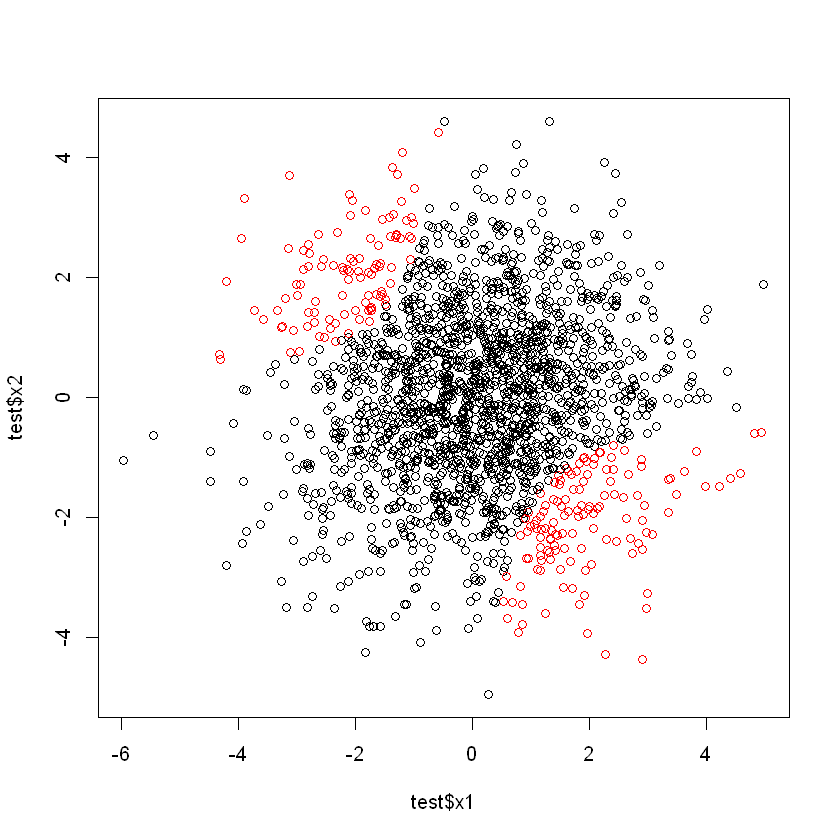

In [78]:
plot(test$x1, test$x2, col=ifelse(test$predicted==0, "black", "red"))

# Decision Tree

In [79]:
train <- rawtrain
test <- rawtest

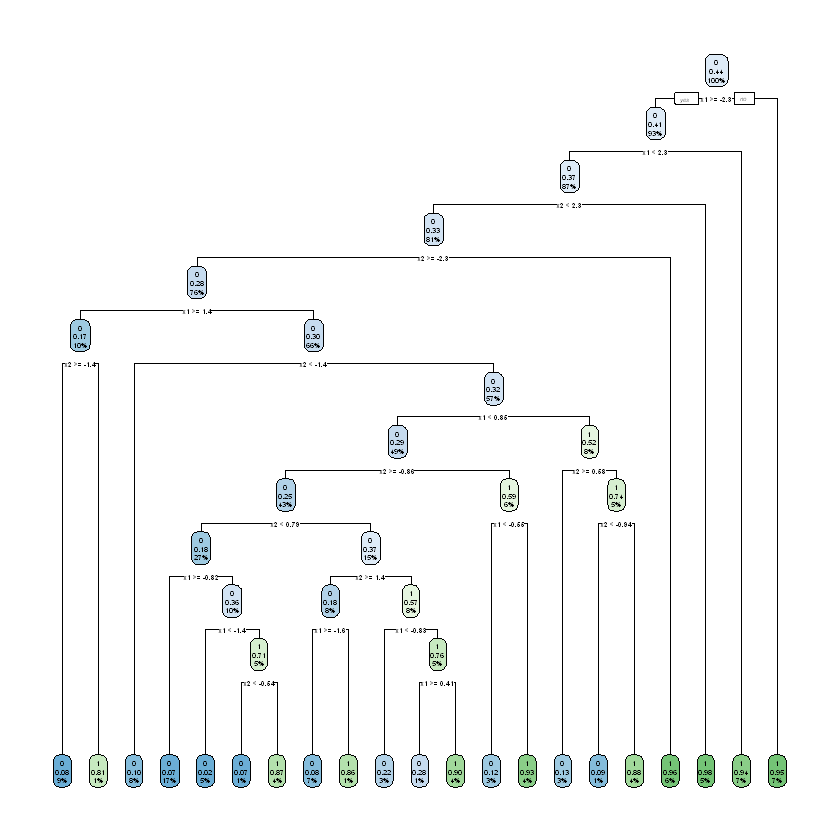

In [80]:
rtree_fit <- rpart(y ~ x1+x2, train) 
rpart.plot(rtree_fit)

In [81]:
test$predicted <- predict(rtree_fit, test,type = "class")
test$predicted <- as.factor(test$predicted)
confusionMatrix(test$predicted, test$y)

Confusion Matrix and Statistics

          Reference
Prediction    0    1
         0 1032  108
         1   83  777
                                         
               Accuracy : 0.9045         
                 95% CI : (0.8908, 0.917)
    No Information Rate : 0.5575         
    P-Value [Acc > NIR] : < 2e-16        
                                         
                  Kappa : 0.8059         
 Mcnemar's Test P-Value : 0.08246        
                                         
            Sensitivity : 0.9256         
            Specificity : 0.8780         
         Pos Pred Value : 0.9053         
         Neg Pred Value : 0.9035         
             Prevalence : 0.5575         
         Detection Rate : 0.5160         
   Detection Prevalence : 0.5700         
      Balanced Accuracy : 0.9018         
                                         
       'Positive' Class : 0              
                                         

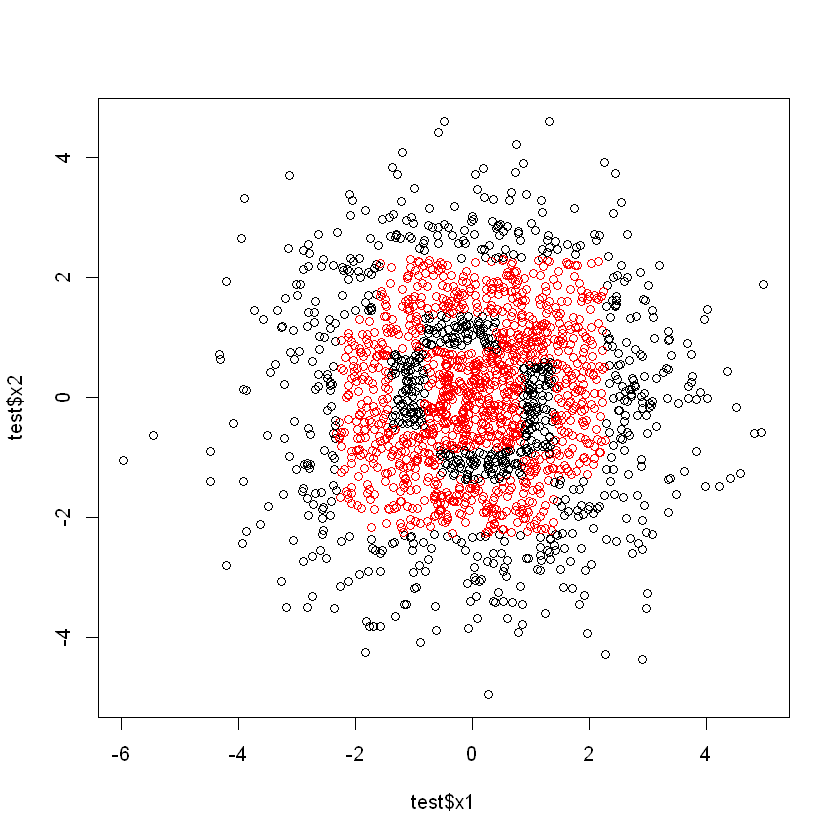

In [82]:
plot(test$x1, test$x2, col=ifelse(test$predicted==0, "red", "black"))

In [83]:
train <- rawtrain
test <- rawtest

In [84]:
fit.svm <-  svm(y~x1+x2, data=train, kernel="radial")

In [85]:
test$predicted <- predict(fit.svm, test,type = "response")
test$predicted <- as.factor(test$predicted)
confusionMatrix(test$predicted, test$y)

Confusion Matrix and Statistics

          Reference
Prediction    0    1
         0 1109  414
         1    6  471
                                          
               Accuracy : 0.79            
                 95% CI : (0.7715, 0.8077)
    No Information Rate : 0.5575          
    P-Value [Acc > NIR] : < 2.2e-16       
                                          
                  Kappa : 0.5531          
 Mcnemar's Test P-Value : < 2.2e-16       
                                          
            Sensitivity : 0.9946          
            Specificity : 0.5322          
         Pos Pred Value : 0.7282          
         Neg Pred Value : 0.9874          
             Prevalence : 0.5575          
         Detection Rate : 0.5545          
   Detection Prevalence : 0.7615          
      Balanced Accuracy : 0.7634          
                                          
       'Positive' Class : 0               
                                          

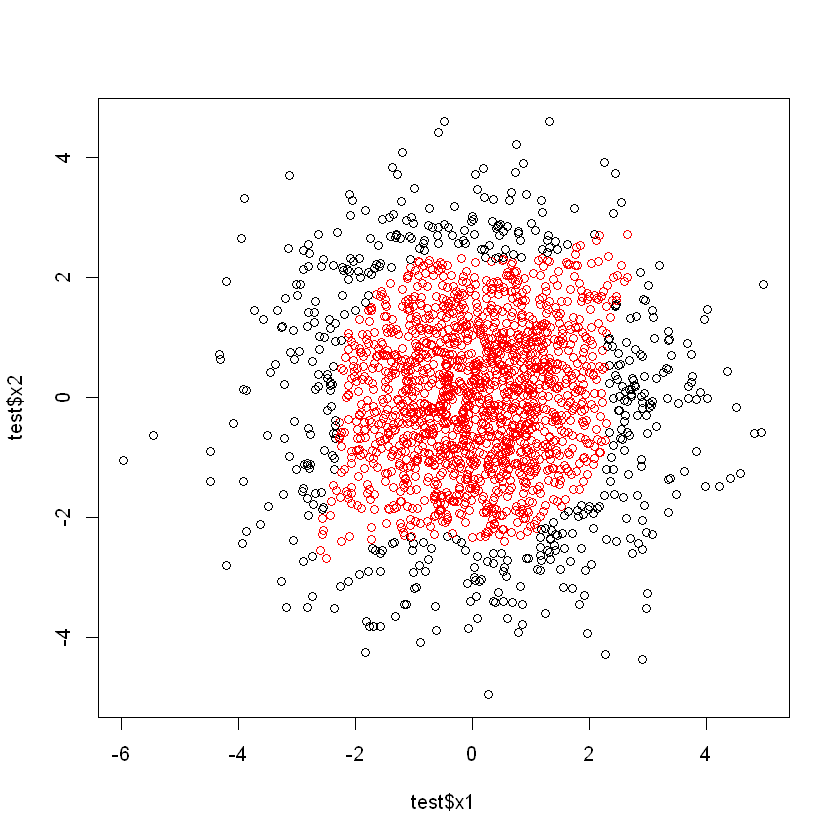

In [86]:
plot(test$x1, test$x2, col=ifelse(test$predicted==0, "red", "black"))

In [87]:
# write.csv(data, "simulate-police.csv")